In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import datetime as dt
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [115]:
test = pd.read_csv('../input/test.csv')
shop = pd.read_csv('../input/shops.csv')
submission = pd.read_csv('../input/sample_submission.csv')
sales = pd.read_csv('../input/sales_train_v2.csv')
items = pd.read_csv('../input/items.csv')
item_category = pd.read_csv('../input/item_categories.csv')

In [47]:
sales['date'] = pd.to_datetime(sales.date).dt.date
sales[sales.item_price < 0]['item_price'] = 0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
#X_train = pd.read_csv('X_train.csv')

In [49]:
sales['unique_shop_item'] = sales.shop_id.astype(str)  + '_' + sales.item_id.astype(str)
sales['unique_block_and_item'] = sales.date_block_num.astype(str) + '_' + sales.item_id.astype(str)
sales['month_price_drift'] = np.nan

# Price volatility

In [50]:
price_aggregates = sales.groupby(['date_block_num', 'item_id']).agg({'item_price' : ['mean', 'std', 'max', 'min']})

In [51]:
price_aggregates.columns = price_aggregates.columns.droplevel(0)
price_aggregates.reset_index(inplace=True)

In [52]:
price_aggregates['std'] = price_aggregates['std'].fillna(0)
price_aggregates[price_aggregates['std'] <= 0]['std'] = price_aggregates[price_aggregates['std'] <= 0]['mean'] / 100.0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
price_aggregates['mean/std'] = price_aggregates['mean']/price_aggregates['std']
price_aggregates['max/min'] = price_aggregates['max']/price_aggregates['min']
price_aggregates.loc[price_aggregates['mean/std'] == np.inf, 'mean/std'] = -1.0
price_aggregates.loc[pd.isnull(price_aggregates['mean/std']) == True, 'mean/std'] = -1.0

In [54]:
price_aggregates.describe()

,date_block_num,item_id,mean,std,max,min,mean/std,max/min
count,233912.000000,233912.000000,233912.000000,233912.000000,233912.000000,233912.000000,2.339120e+05,233912.000000
mean,14.941944,11308.922377,676.123684,21.356367,696.834254,632.821432,2.525082e+02,2.121493
std,9.642430,6208.348238,1516.669010,90.077452,1563.321670,1472.579463,1.133355e+04,52.900156
min,0.000000,0.000000,0.100000,0.000000,0.100000,-1.000000,-1.000000e+00,-2499.000000
25%,7.000000,5976.000000,183.545455,0.000000,198.000000,149.000000,-1.000000e+00,1.000000
50%,14.000000,11391.000000,299.000000,0.000000,299.000000,299.000000,-1.000000e+00,1.000000
75%,23.000000,16600.000000,699.000000,15.000000,699.000000,639.000000,4.591395e+00,1.198408
max,33.000000,22169.000000,307980.000000,16946.028517,307980.000000,307980.000000,3.741999e+06,5198.000000


# Price segments

In [59]:
sales.item_price.describe() # take 25, 50, 75 quartiles as estimators

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

# Seasonality pattern

In [88]:
holiday_months = [12, 2, 3]
bad_month = [1, 11, 5, 6, 7] # January after New Year, November before New Year, May and summer
sales['month_num'] = sales['date'].apply(lambda x: x.month)

In [93]:
agg = pd.DataFrame(sales.groupby(['month_num'])['item_cnt_day'].sum())

In [94]:
agg.reset_index(inplace=True)

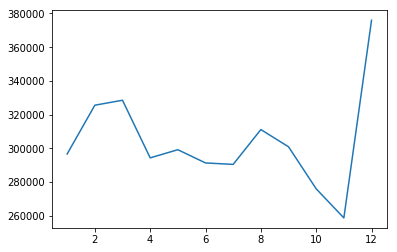

In [96]:
plt.plot(agg.month_num, agg.item_cnt_day)

# Is online shop feature

In [103]:
agg = pd.DataFrame(sales.groupby(['shop_id'])['item_cnt_day'].sum())
agg.reset_index(inplace=True)

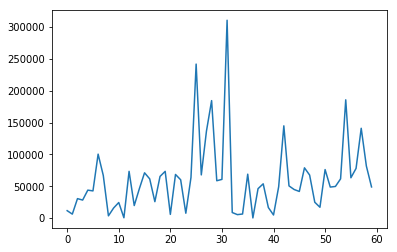

In [105]:
plt.plot(agg.shop_id, agg.item_cnt_day)

In [117]:
agg = pd.DataFrame(sales.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum())
agg.reset_index(inplace=True)

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895ebee10>,
 <a list of 2 Text xticklabel objects>)

Text(0.5,1,'0')

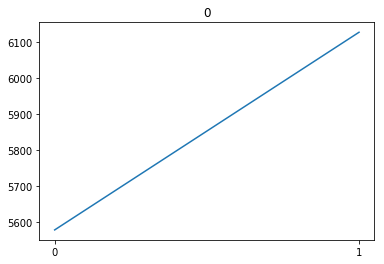

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38adf80550>,
 <a list of 2 Text xticklabel objects>)

Text(0.5,1,'1')

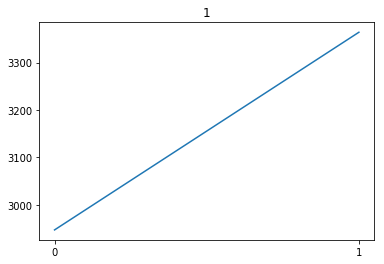

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abe78e50>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'2')

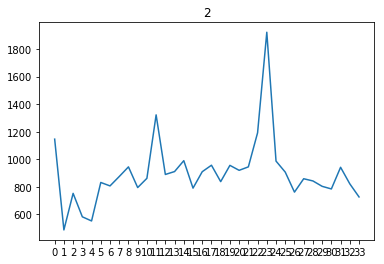

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38b41441d0>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'3')

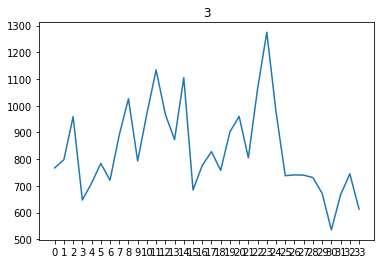

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae0a3650>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'4')

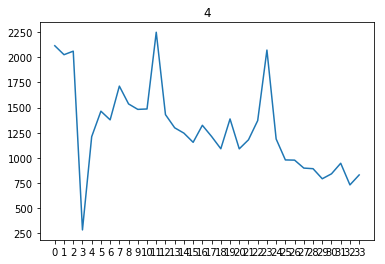

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab7f1ad0>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'6')

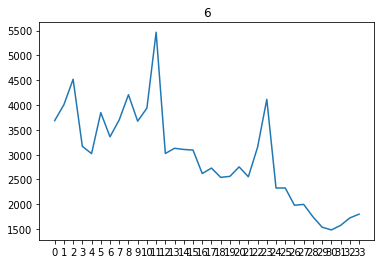

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae034f50>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'7')

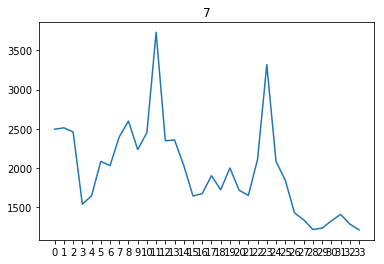

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abd47ed0>,
 <a list of 4 Text xticklabel objects>)

Text(0.5,1,'8')

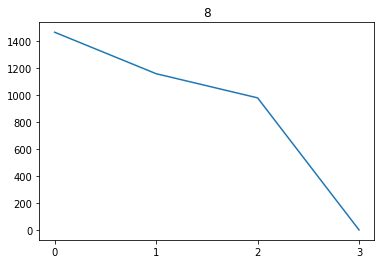

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abc6d6d0>,
 <a list of 33 Text xticklabel objects>)

Text(0.5,1,'10')

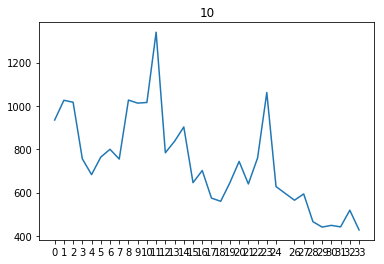

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab787150>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'12')

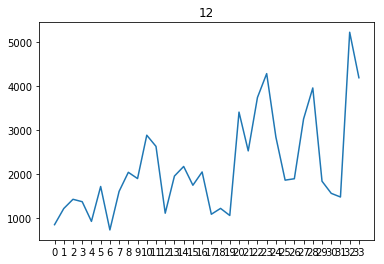

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abdef250>,
 <a list of 20 Text xticklabel objects>)

Text(0.5,1,'13')

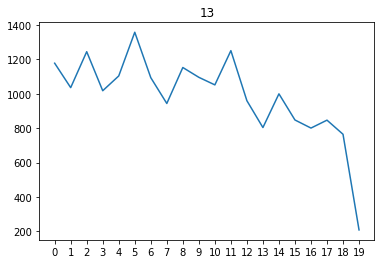

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895e414d0>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'14')

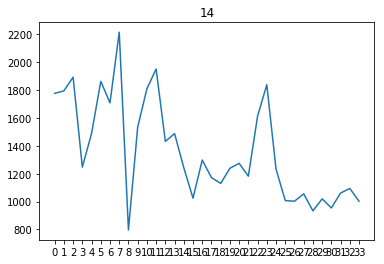

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abb1e450>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'15')

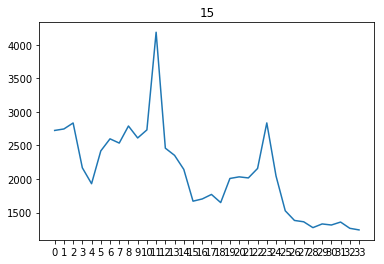

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abbd5a50>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'16')

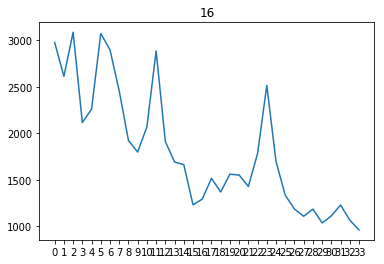

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abcaea90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'18')

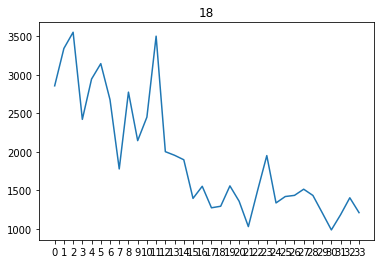

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895e43b90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'19')

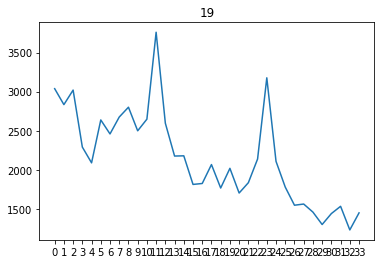

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abb45550>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'21')

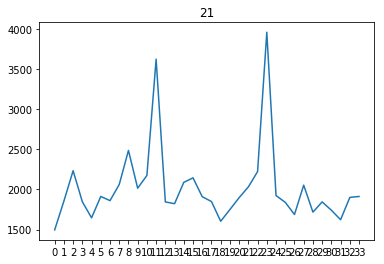

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38adf80f50>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'22')

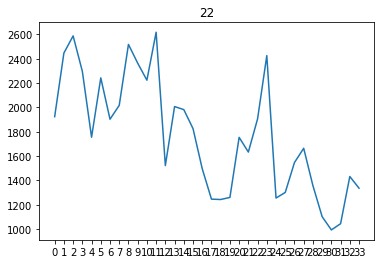

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab6b0b10>,
 <a list of 4 Text xticklabel objects>)

Text(0.5,1,'23')

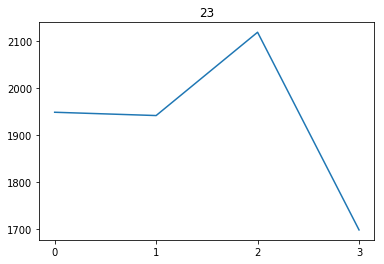

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab9c9310>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'24')

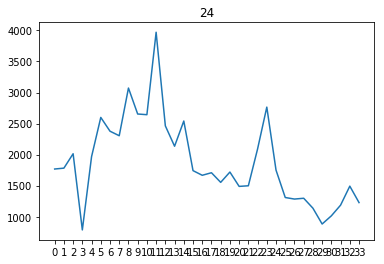

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab931d10>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'25')

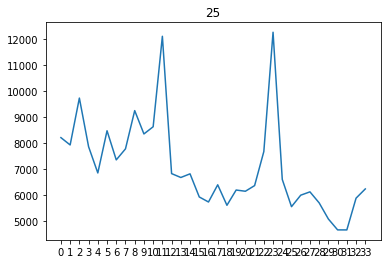

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abb9ee10>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'26')

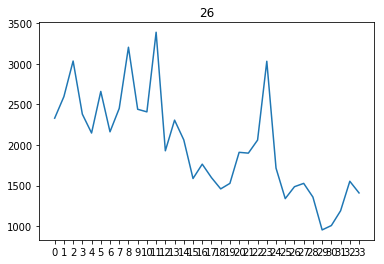

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895e54150>,
 <a list of 32 Text xticklabel objects>)

Text(0.5,1,'27')

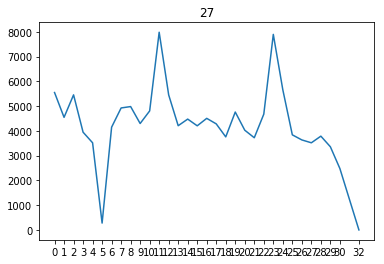

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abde2b90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'28')

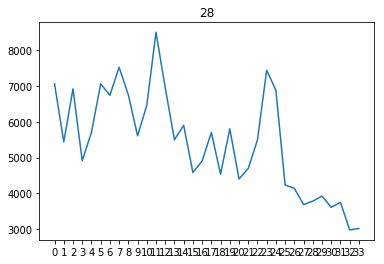

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab759190>,
 <a list of 29 Text xticklabel objects>)

Text(0.5,1,'29')

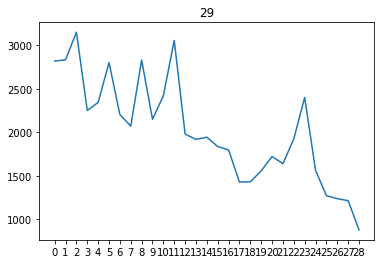

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae089890>,
 <a list of 26 Text xticklabel objects>)

Text(0.5,1,'30')

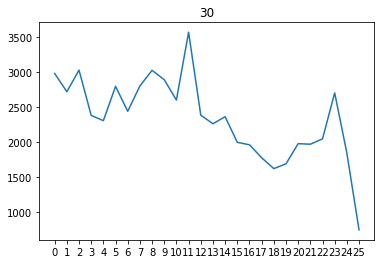

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abc13550>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'31')

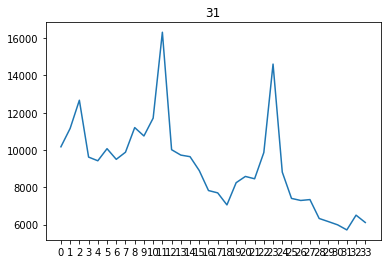

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab4bea90>,
 <a list of 7 Text xticklabel objects>)

Text(0.5,1,'32')

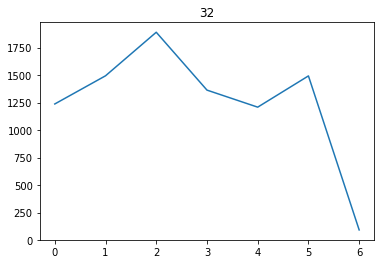

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae0adc90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'35')

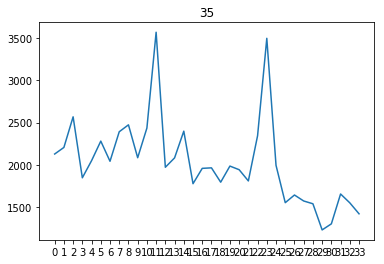

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38a13fc650>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'37')

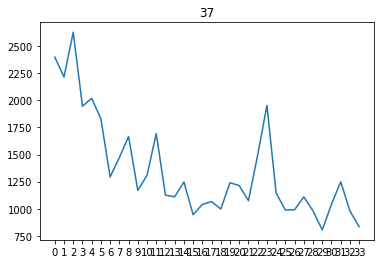

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae00ba90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'38')

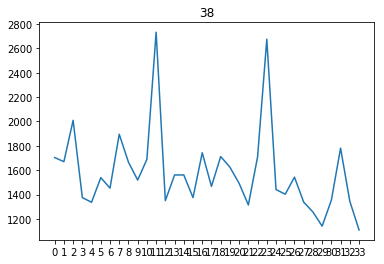

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae046410>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'41')

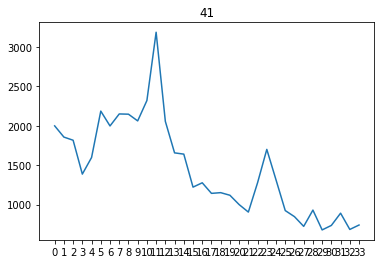

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae086650>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'42')

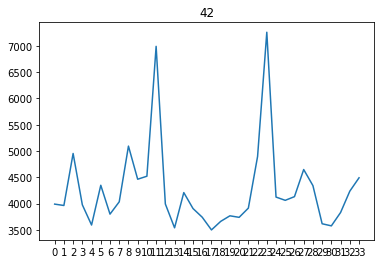

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab8ff5d0>,
 <a list of 25 Text xticklabel objects>)

Text(0.5,1,'43')

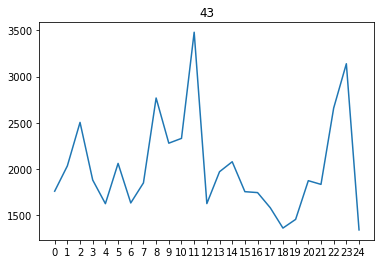

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abd31850>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'44')

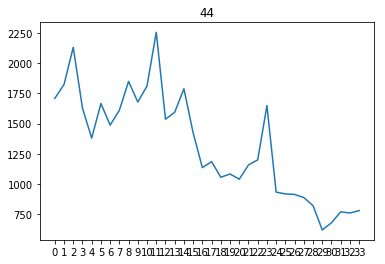

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abd5e2d0>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'45')

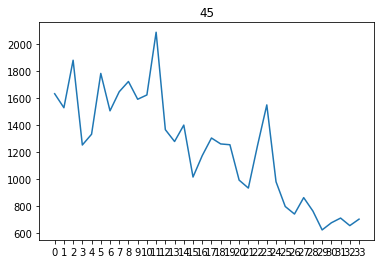

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abdbc250>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'46')

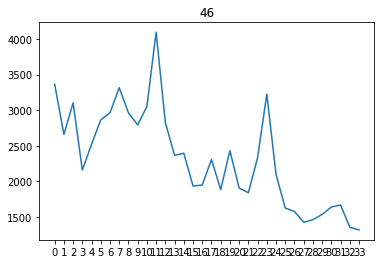

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab95a790>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'47')

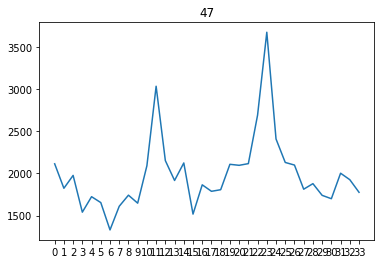

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab9f56d0>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'50')

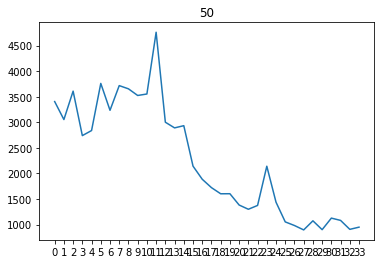

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abab5750>,
 <a list of 33 Text xticklabel objects>)

Text(0.5,1,'51')

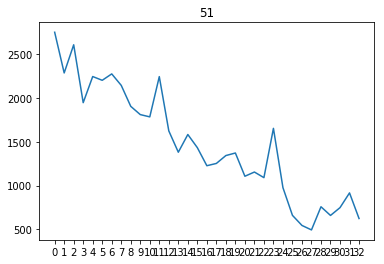

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab69d290>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'52')

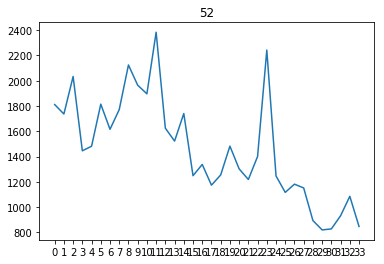

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab73e510>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'53')

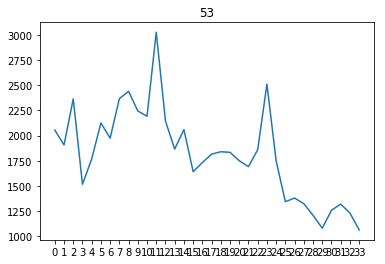

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae075610>,
 <a list of 28 Text xticklabel objects>)

Text(0.5,1,'54')

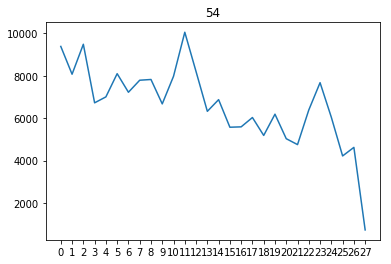

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38adf80b90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'56')

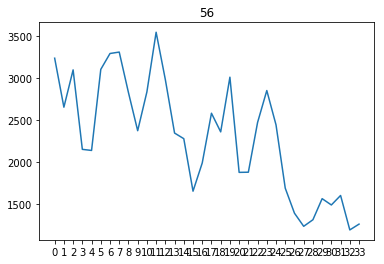

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab4fda90>,
 <a list of 34 Text xticklabel objects>)

Text(0.5,1,'59')

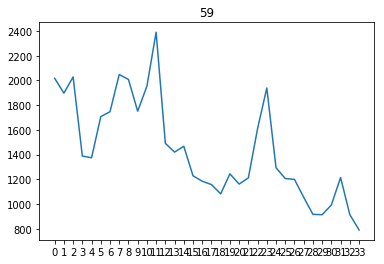

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab963510>,
 <a list of 33 Text xticklabel objects>)

Text(0.5,1,'5')

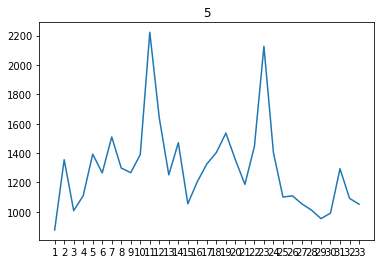

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ae00fa50>,
 <a list of 32 Text xticklabel objects>)

Text(0.5,1,'57')

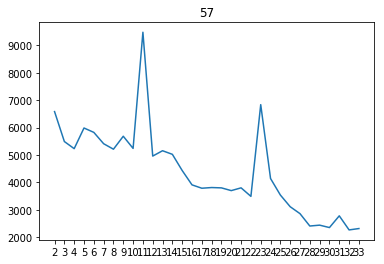

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab513f90>,
 <a list of 32 Text xticklabel objects>)

Text(0.5,1,'58')

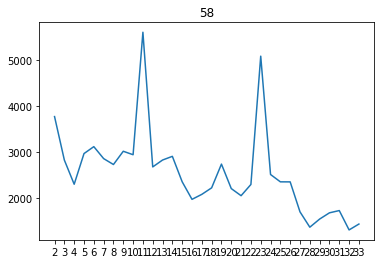

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38ab508bd0>,
 <a list of 30 Text xticklabel objects>)

Text(0.5,1,'55')

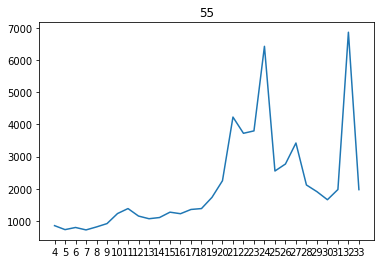

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38b40c7e50>,
 <a list of 20 Text xticklabel objects>)

Text(0.5,1,'17')

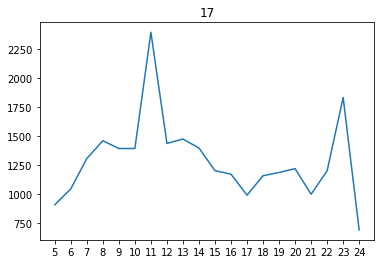

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38b410ea10>,
 <a list of 4 Text xticklabel objects>)

Text(0.5,1,'9')

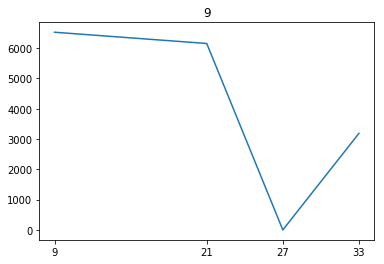

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895e29c10>,
 <a list of 23 Text xticklabel objects>)

Text(0.5,1,'49')

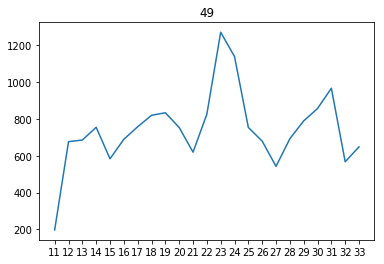

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abc42950>,
 <a list of 20 Text xticklabel objects>)

Text(0.5,1,'39')

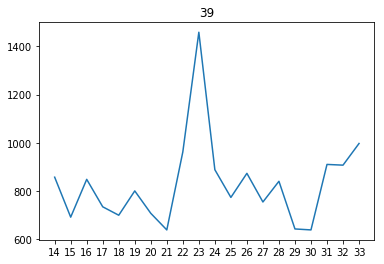

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abbdd290>,
 <a list of 11 Text xticklabel objects>)

Text(0.5,1,'40')

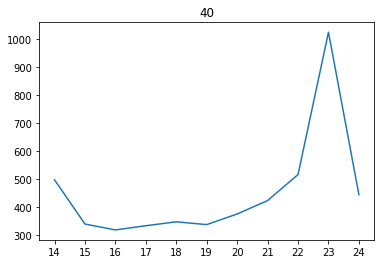

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f3895e29d10>,
 <a list of 19 Text xticklabel objects>)

Text(0.5,1,'48')

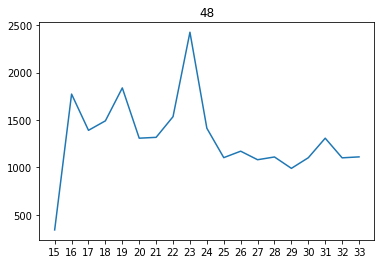

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38adfad510>,
 <a list of 16 Text xticklabel objects>)

Text(0.5,1,'34')

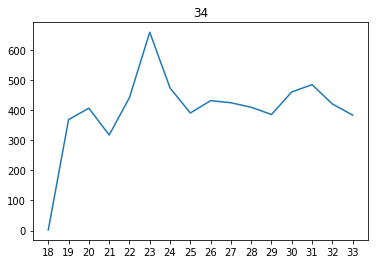

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abd07d50>,
 <a list of 9 Text xticklabel objects>)

Text(0.5,1,'33')

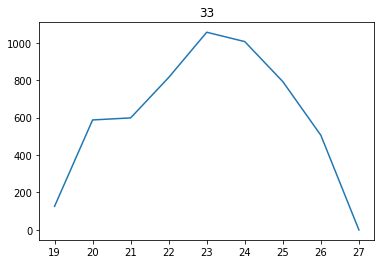

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38adf819d0>,
 <a list of 2 Text xticklabel objects>)

Text(0.5,1,'20')

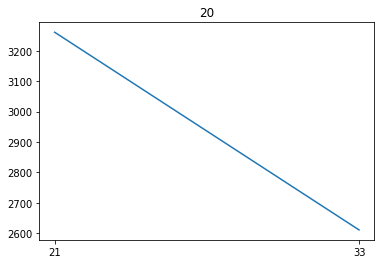

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abe30b90>],
 <a list of 1 Text xticklabel objects>)

Text(0.5,1,'11')

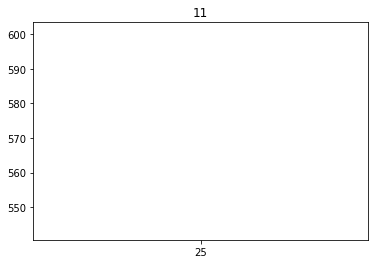

<Figure size 432x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f38abd34a10>],
 <a list of 1 Text xticklabel objects>)

Text(0.5,1,'36')

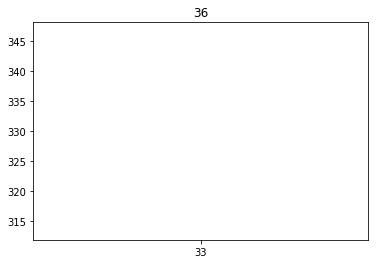

In [120]:
for shop in agg.shop_id.unique():
    temp = agg[agg.shop_id == shop]
    plt.figure()
    plt.plot(temp.date_block_num, temp.item_cnt_day)
    plt.xticks(temp.date_block_num)
    plt.title(shop)
    plt.show()

In [116]:
shop

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [101]:
agg.reset_index(inplace=True)

In [102]:
chunk  = agg[agg.]

,month_num,shop_id,item_cnt_day
0,1,0,3626.0
1,1,1,1955.0
2,1,2,2207.0
3,1,3,2058.0
4,1,4,3616.0
5,1,5,2924.0
6,1,6,8053.0
7,1,7,5505.0
8,1,8,747.0
9,1,9,287.0
